# Load packages

In [1]:
using JudiLing
using CSV # read csv files into dataframes
using DataFrames # parse data into dataframes
using Plots, StatsPlots # to look at some of the measures

using JudiLingMeasures

# Setup
Use standard latin example, explanations are [here](https://github.com/MegamindHenry/JudiLing.jl).

In [2]:
# Comment this in if you haven't downloaded the latin datasets already
download("https://osf.io/2ejfu/download", joinpath(@__DIR__, "latin_train.csv"))
download("https://osf.io/bm7y6/download", joinpath(@__DIR__,"latin_val.csv"))

latin_train =
    DataFrame(CSV.File(joinpath(@__DIR__, "latin_train.csv")))
latin_val =
    DataFrame(CSV.File(joinpath(@__DIR__, "latin_val.csv")))

cue_obj_train, cue_obj_val = JudiLing.make_cue_matrix(
    latin_train,
    latin_val,
    grams = 3,
    target_col = :Word,
    tokenized = false,
    keep_sep = false
)

n_features = size(cue_obj_train.C, 2)
S_train, S_val = JudiLing.make_S_matrix(
    latin_train,
    latin_val,
    ["Lexeme"],
    ["Person", "Number", "Tense", "Voice", "Mood"],
    ncol = n_features
)

G_train = JudiLing.make_transform_matrix(S_train, cue_obj_train.C)
F_train = JudiLing.make_transform_matrix(cue_obj_train.C, S_train)

Chat_train = S_train * G_train
Chat_val = S_val * G_train
Shat_train = cue_obj_train.C * F_train
Shat_val = cue_obj_val.C * F_train

A = cue_obj_train.A
max_t = JudiLing.cal_max_timestep(latin_train, latin_val, :Word)

res_learn_train, gpi_learn_train, rpi_learn_train = JudiLing.learn_paths_rpi(
    latin_train,
    latin_train,
    cue_obj_train.C,
    S_train,
    F_train,
    Chat_train,
    A,
    cue_obj_train.i2f,
    cue_obj_train.f2i, # api changed in 0.3.1
    gold_ind = cue_obj_train.gold_ind,
    Shat_val = Shat_train,
    check_gold_path = true,
    max_t = max_t,
    max_can = 10,
    grams = 3,
    threshold = 0.05,
    tokenized = false,
    sep_token = "_",
    keep_sep = false,
    target_col = :Word,
    issparse = :dense,
    verbose = false,
);

res_learn_val, gpi_learn_val, rpi_learn_val = JudiLing.learn_paths_rpi(
    latin_train,
    latin_val,
    cue_obj_train.C,
    S_val,
    F_train,
    Chat_val,
    A,
    cue_obj_train.i2f,
    cue_obj_train.f2i, # api changed in 0.3.1
    gold_ind = cue_obj_val.gold_ind,
    Shat_val = Shat_val,
    check_gold_path = true,
    max_t = max_t,
    max_can = 10,
    grams = 3,
    threshold = 0.05,
    is_tolerant = true,
    tolerance = -0.1,
    max_tolerance = 2,
    tokenized = false,
    sep_token = "-",
    keep_sep = false,
    target_col = :Word,
    issparse = :dense,
    verbose = false,
);


# General help with measures

Each measure comes with a documentation, which you can call via

In [3]:
?JudiLingMeasures.L1Norm

```
L1Norm(M::Union{JudiLing.SparseMatrixCSC, Matrix})
```

Compute the L1 Norm of each row of a matrix.

# Examples

```jldoctest
julia> Shat = [[1 2 3]; [-1 -2 -3]; [1 2 3]]
julia> L1Norm(Shat)
3-element Vector{Int64}:
 6
 6
 6
```


# Computing measures

## Computing all available measures

JudiLingMeasures has an implemented function which returns almost all currently available measures for the data of interest. The only ones not included are those which return multiple values per wordform, which are "Functional Load" and "Semantic Support for Form" with `sum_supports=false`. 

"Production Uncertainty" is computationally very heavy for large C matrices, therefore its computation is turned off by default and is only calculated when setting `calculate_production_uncertainty = true`.

Finally, the number of semantic neighbours taken into account in the "Semantic Density" measure is controlled with `sem_density_n`, which is set to 8 by default.

The measures can either be computed for the training data...

In [4]:
dat_all_measures_train = JudiLingMeasures.compute_all_measures_train(latin_train, # the training data
                                                         cue_obj_train, # the cue_obj of the training data
                                                         Chat_train, # the Chat of the training data
                                                         S_train, # the S matrix of the training data
                                                         Shat_train, # the Shat matrix of the training data
                                                         F_train, # the F matrix
                                                         G_train,
                                                         res_learn_train=res_learn_train, # the output of learn_paths for the training data
                                                         gpi_learn_train=gpi_learn_train, # the gpi_learn object of the training data
                                                         rpi_learn_train=rpi_learn_train, # the rpi_learn object of the training data
                                                         sem_density_n = 8,
                                                         calculate_production_uncertainty = true);

Recognition not implemented


...or the validation data:

In [5]:
dat_all_measures_val = JudiLingMeasures.compute_all_measures_val(latin_val, # the validation data
                                                         cue_obj_train, # the cue_obj of the training data
                                                         cue_obj_val, # the cue_obj of the validation data
                                                         Chat_val, # the Chat of the validation data
                                                         S_train, # the S matrix of the training data
                                                         S_val, # the S matrix of the validation data
                                                         Shat_val, # the Shat matrix of the validation data
                                                         F_train, # the F matrix
                                                         G_train, # the G matrix
                                                         res_learn_val=res_learn_val, # the output of learn_paths for the validation data
                                                         gpi_learn_val=gpi_learn_val, # the gpi_learn object of the validation data
                                                         rpi_learn_val=rpi_learn_val, # the rpi_learn object of the validation data
                                                         sem_density_n = 8,
                                                         calculate_production_uncertainty = true);

Recognition not implemented


The resulting dataframes include all the measures:

In [6]:
dat_all_measures_train[1:10, [2:3;19:end]]

,Word,Lexeme,ComprehensionUncertainty,ProductionUncertainty,DistanceTravelledG
,String,String,Float64,Float64,Float64
1,vocoo,vocare,1.3711e5,78032.2,0.185357
2,vocaas,vocare,139166.0,65289.0,0.38653
3,vocat,vocare,1.39437e5,74687.4,0.339522
4,vocaamus,vocare,1.39161e5,75512.4,0.709293
5,vocaatis,vocare,1.39334e5,68035.3,0.835975
6,vocant,vocare,1.40762e5,85206.3,0.611335
7,clamoo,clamare,1.32243e5,80443.6,0.189687
8,clamaas,clamare,1.3595e5,71387.6,0.383519
9,clamat,clamare,1.37001e5,72946.3,0.344913


In [7]:
dat_all_measures_val[1:10, [2:3;19:end]]

,Word,Lexeme,ComprehensionUncertainty,ProductionUncertainty,DistanceTravelledG
,String,String,Float64,Float64,Float64
1,doceebitur,docere,1.82057e5,1.53375e5,1.22177
2,audieebaas,audire,1.68241e5,1.41694e5,1.03244
3,cuccurerint,currere,1.72698e5,1.28144e5,1.00977
4,carpereetis,carpere,1.79904e5,1.16837e5,1.33702
5,carpiaamus,carpere,1.75175e5,1.46193e5,0.909963
6,carpeebant,carpere,1.85939e5,1.36768e5,1.11279
7,carpiaamur,carpere,1.40676e5,1.19414e5,1.07782
8,terreeret,terrere,1.77671e5,1.30927e5,1.07317
9,vocaavit,vocare,1.94574e5,1.12275e5,0.7076


Some visualisation of the resulting measures:

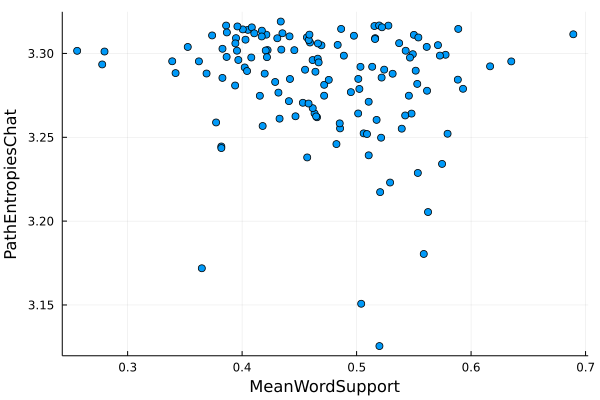

In [8]:
plot(dat_all_measures_val.MeanWordSupport, 
     dat_all_measures_val.PathEntropiesChat, seriestype=:scatter, label=false,
     xlab="MeanWordSupport", ylab="PathEntropiesChat")

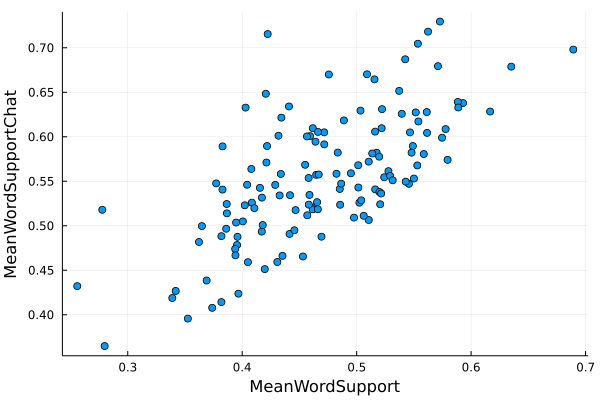

In [9]:
plot(dat_all_measures_val.MeanWordSupport, 
     dat_all_measures_val.MeanWordSupportChat, seriestype=:scatter, label=false,
     xlab="MeanWordSupport", ylab="MeanWordSupportChat")

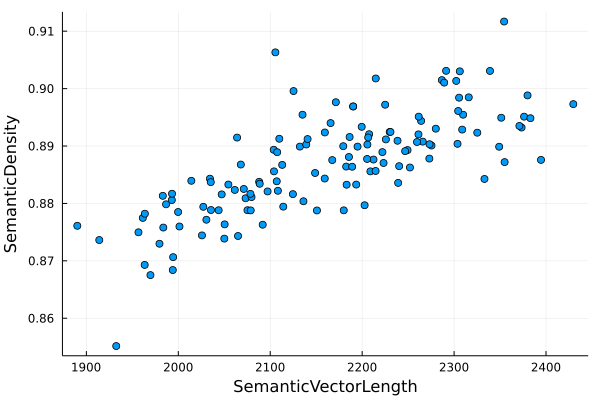

In [10]:
plot(dat_all_measures_val.L1Shat, 
     dat_all_measures_val.SemanticDensity, seriestype=:scatter, label=false,
     xlab="SemanticVectorLength", ylab="SemanticDensity")

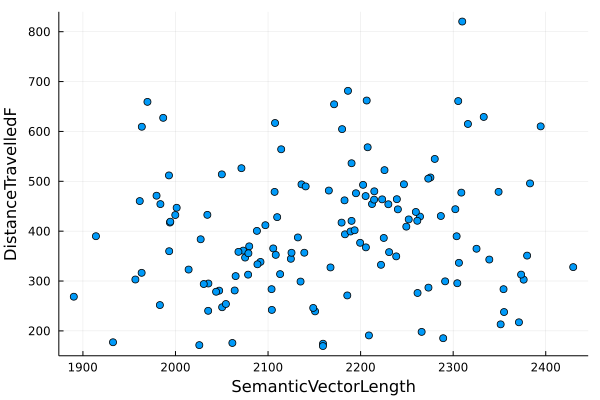

In [11]:
plot(dat_all_measures_val.L1Shat, 
     dat_all_measures_val.DistanceTravelledF, seriestype=:scatter, label=false,
     xlab="SemanticVectorLength", ylab="DistanceTravelledF")

Functional Load and Semantic Support for Form with `sum_supports=false` can of course also be calculated by calling:

In [12]:
JudiLingMeasures.functional_load(F_train, Shat_val, cue_obj_val, method="corr")

134-element Vector{Any}:
 [0.8054846086920117, 0.8054846086920251, 0.18620156596226056, 0.5487175904656353, -0.12079223317054687, 0.1428104338646634, 0.1942316652159979, 0.5874095357852527, 0.4860115992685573, 0.22677637186291358]
 [0.7520055638892348, 0.7520055638892333, 0.7520055638892128, 0.1905730861011827, 0.023489991688054757, 0.2428206790870794, 0.2503626740840919, 0.2631848587399136, 0.10502853977722314, 0.5444028687147034]
 [0.6491216066939423, 0.2907667242141188, 0.29076672421411837, 0.2907667242141185, 0.6491216066939424, 0.5423763003401628, -0.007890391076925142, -0.06057860876980073, -0.01591998047613558, -0.015919980476170412, 0.5097019419161156]
 [0.5170341968149574, 0.517034196814926, 0.5170341968149261, -0.3486350812706477, -0.20360625021023704, 0.4602907637726019, -0.14608050691700167, 0.5907847931541687, 0.6860211453630974, 0.14105659038474153, 0.43369808945016386]
 [0.6736533582970547, 0.6736533582969638, 0.6736533582969639, 0.5554586751233193, 0.4805830632777732, 0

In [13]:
JudiLingMeasures.semantic_support_for_form(cue_obj_val, Chat_val, sum_supports=false)

134-element Vector{Any}:
 [0.9955759324264202, 0.9955759324264202, 0.5303705917856949, 0.38388194509780615, 0.2719354831620363, 0.0452699820825019, 0.006187586498676226, 0.002228815529335267, 0.23749807177618223, 0.48809696171678385]
 [1.0156083795141468, 1.0156083795141468, 1.0156083795141468, 0.4044657884580168, 0.4930003656515859, 0.6257729606915924, 0.5631115041825869, 0.5913940071347336, 0.49045329609276894, 0.5382211648315605]
 [0.9893837699613413, 0.5402110291682001, 0.5402110291682001, 0.5402110291682001, 0.9893837699613413, 0.3428774737604364, 0.43026832319286623, 0.4568763570859641, 0.13305685910029127, 0.13305685910029127, 0.3675688221247535]
 [0.9937534558424213, 0.9937534558424213, 0.9937534558424213, 0.5631208359484638, 0.33343588316051526, 0.5227291720500075, 0.9140426805785028, 0.09017952341949818, 0.14732352213129346, 0.39997359020594764, 0.4524341227655768]
 [0.9711548285584383, 0.9711548285584383, 0.9711548285584383, 0.41614552746220185, 0.28303330093719015, 0.300374

As can be seen, they both return multiple values per wordform.

## Computing a custom set of measures

In the following, we implement a function which computes a few of the available measures, for demonstration purposes. Let's say we are interested primarily in measures of comprehension and production **accuracy**. We might settle on the following functions (as an example, please also consider other measures of you are interested in mapping accuracy):

- TargetCorrelation
- rank
- SCPP
- C-Precision
- PathEntropiesChat

We therefore define the following function:

In [14]:
function compute_accuracy_measures(data_val::DataFrame,
                                  cue_obj_train::JudiLing.Cue_Matrix_Struct,
                                  cue_obj_val::JudiLing.Cue_Matrix_Struct,
                                  Chat_val::Union{JudiLing.SparseMatrixCSC, Matrix},
                                  S_train,
                                  S_val::Union{JudiLing.SparseMatrixCSC, Matrix},
                                  Shat_val::Union{JudiLing.SparseMatrixCSC, Matrix},
                                  res_learn_val::Array{Array{JudiLing.Result_Path_Info_Struct,1},1},
                                  gpi_learn_val::Array{JudiLing.Gold_Path_Info_Struct,1},
                                  rpi_learn_val::Array{JudiLing.Gold_Path_Info_Struct,1})
    # MAKE PREPARATIONS

    # generate additional objects for the measures such as
    # - results: copy of data_val for storing the measures in
    # - cor_s: the correlation matrix between Shat and S
    # - df: DataFrame of res_learn, the output of learn_paths
    # - pred_df: DataFrame with path supports for the predicted forms produced by learn_paths
    results, cor_s, df, pred_df = JudiLingMeasures.make_measure_preparations(data_val, S_train, S_val, Shat_val,
                                    res_learn_val, cue_obj_train, cue_obj_val, rpi_learn_val)


    # CALCULATE MEASURES

    # comprehension accuracy
    results[!,"TargetCorrelation"] = JudiLingMeasures.target_correlation(cor_s)
    results[!,"rank"] = JudiLingMeasures.rank(cor_s)

    # production accuracy
    results[!,"SCPP"] = JudiLingMeasures.SCPP(df, results)
    results[!,"C-Precision"] = JudiLingMeasures.c_precision(Chat_val, cue_obj_val.C)
    results[!,"PathEntropiesChat"] = JudiLingMeasures.path_entropies_chat(res_learn_val, Chat_val)


    results
end

compute_accuracy_measures (generic function with 1 method)

Now we can call this function.

In [15]:
dat_accuracy_measures = compute_accuracy_measures(latin_val, # the data of interest
                                                 cue_obj_train, # the cue_obj of the training data
                                                 cue_obj_val, # the cue_obj of the data of interest
                                                 Chat_val, # the Chat of the data of interest
                                                 S_train,
                                                 S_val, # the S matrix of the data of interest
                                                 Shat_val, # the Shat matrix of the data of interest
                                                 res_learn_val, # the output of learn_paths for the data of interest
                                                 gpi_learn_val, # the gpi_learn object of the data of interest
                                                 rpi_learn_val); # the rpi_learn object of the data of interest

In [16]:
first(dat_accuracy_measures, 10)

,Column1,Word,Lexeme,Person,Number,Tense,Voice,Mood,TargetCorrelation
,Int64,String,String,String,String,String,String,String,Float64
1,309,doceebitur,docere,p3,sg,future,passive,ind,0.994004
2,62,audieebaas,audire,p2,sg,past,active,ind,0.990064
3,576,cuccurerint,currere,p3,pl,perfect,active,subj,0.995036
4,473,carpereetis,carpere,p2,pl,past,active,subj,0.996071
5,376,carpiaamus,carpere,p1,pl,present,active,subj,0.993369
6,90,carpeebant,carpere,p3,pl,past,active,ind,0.993135
7,424,carpiaamur,carpere,p1,pl,present,passive,subj,0.992946
8,447,terreeret,terrere,p3,sg,past,active,subj,0.99451
9,147,vocaavit,vocare,p3,sg,perfect,active,ind,0.994013
